In [7]:
import pandas 
import matplotlib
import matplotlib.pyplot as plt

In [2]:
tf_parameters = ['step', 'uBA','sbA','uBB','sbB','pA','pb','pc', 'pm','umax','nl',
                 'eLJ','uc','cost']
df_params = pandas.DataFrame(columns = tf_parameters)

In [3]:
# %load tf-optimizer.py
#from __future__ import absolute_import
#from __future__ import division
from __future__ import print_function

import pandas
import numpy as np
import random
from numpy.polynomial.hermite  import hermgauss
import tensorflow as tf

kT = 1.986e-3*300.0 #1/kT at 300K 
beta = 1./kT

xg,wg = hermgauss(15)
xgauss = np.float32(xg)
wgauss = np.float32(wg)
ngauss = xgauss.size


## Read in data
ulambda = pandas.read_csv("sampl4-oah-b7eqnosc.repl.cycle.totE.potE.temp.lambda.ebind.dat",delim_whitespace=True, 
                          header=None,names=["replica","cycle","totE",
                                             "potE","temp","Lambda","ebind"])

#ulambda = pandas.read_csv("bcd-nabumetone.repl",delim_whitespace=True, 
#                          header=None,names=["replica","cycle","totE",
#                          "potE","temp","Lambda","ebind"])




u = np.float32(ulambda['ebind'])*beta #transform in units of kT
lmbs = np.float32(ulambda['Lambda'])
cycles = np.int32(ulambda['cycle'])

#mask = np.logical_and(lmbs < 0.3 , lmbs > 1.e-3)
mask = np.logical_and(lmbs > 1.e-6, cycles > 100)
#mask = np.abs(lmbs - 0.1) < 1.e-6
un = u[mask]
ln = lmbs[mask]

#initial parameters
ubA = -13.953*beta
sbA = 1.906*beta
ubB = -2.334*beta
sbB = 3.238*beta
pA = 2.45e-4
pB = 1. - pA
elj = 20.0*beta # 20.0
uc = 0.5*beta
nl = 4.00 # 2.96
pb = 1.18e-4
pc = 3.00e-2
pm = 1. - pb - pc
umax = 1.e6*beta

#integration grid for Pwca
a = uc
ymax = np.log(umax)/a 
dy = ymax/100.0
xasymp = np.float32(np.exp(a*np.arange(0.,ymax,dy)) - 1.) + 1.e-6
dxasymp = np.float32(xasymp[1:] - xasymp[:-1])
nx = dxasymp.size
xasymp = np.float32(xasymp[:-1])

#dictionary of parameters
params = {}

params['UBA'] = tf.constant(ubA)
#params['UBA'] = tf.get_variable("UBA", initializer=tf.constant(ubA))

params['SIGBA'] = tf.constant(sbA)
#params['SIGBA'] = tf.get_variable("SIGBA", initializer=tf.constant(sbA))

params['UBB'] = tf.constant(ubB)
#params['UBB'] = tf.get_variable("UBB", initializer=tf.constant(ubB))

params['SIGBB'] = tf.constant(sbB)
#params['SIGBB'] = tf.get_variable("SIGBB", initializer=tf.constant(sbB))

params['PA'] =  tf.constant(pA)
#params['PA'] = tf.get_variable("PA", initializer=tf.constant(pA))

params['E'] = tf.constant(elj)
#params['E'] = tf.get_variable("E", initializer=tf.constant(elj))

params['UC'] = tf.constant(uc) #not optimize for now
#params['UC'] = tf.get_variable("UC", initializer=tf.constant(uc))

#params['NL'] =  tf.constant(nl)
params['NL'] =  tf.get_variable("NL", initializer=tf.constant(nl))

#params['PB'] =  tf.constant(pb)
params['PB'] = tf.get_variable("PB", initializer=tf.constant(pb))

#params['PC'] =  tf.constant(pc)
params['PC'] = tf.get_variable("PC", initializer=tf.constant(pc))



pi = tf.constant(np.pi)

ngauss_p = tf.constant(ngauss, dtype=tf.int32)
xgauss_p = tf.constant(np.float32(xgauss), dtype=tf.float32)
wgauss_p = tf.constant(np.float32(wgauss), dtype=tf.float32)

u_p = tf.constant(un, dtype=tf.float32)
lmbs_p = tf.constant(ln, dtype=tf.float32)

xasymp_p = tf.constant(xasymp, dtype=tf.float32)
dxasymp_p = tf.constant(dxasymp, dtype=tf.float32)
nx_p = tf.constant(nx, dtype=tf.int32)


pm_p = tf.constant(pm)

xc = tf.sqrt(params['UC']/params['E'])
a = tf.sqrt(1.+xc)
eps = xc/10.
xm = tf.sqrt(umax/params['E'])
nm = tf.pow(1. - params['NL']*a/xm, -1)

#Gaussian (mixture) for B for all input u's
gbA = tf.exp(-tf.pow(u_p-params['UBA'],2)/(2.0*tf.pow(params['SIGBA'],2)))/(tf.sqrt(2.*pi)*params['SIGBA'])
gbB = tf.exp(-tf.pow(u_p-params['UBB'],2)/(2.0*tf.pow(params['SIGBB'],2)))/(tf.sqrt(2.*pi)*params['SIGBB'])
gb1 = params['PA']*gbA + gbB - params['PA']*gbB

#gaussian at large distance pB(u - umax)
gbAfar = tf.exp(-tf.pow(u_p-umax-params['UBA'],2)/(2.0*tf.pow(params['SIGBA'],2)))/(tf.sqrt(2.*pi)*params['SIGBA'])
gbBfar = tf.exp(-tf.pow(u_p-umax-params['UBB'],2)/(2.0*tf.pow(params['SIGBB'],2)))/(tf.sqrt(2.*pi)*params['SIGBB'])
gbfar = params['PA']*gbAfar + gbBfar - params['PA']*gbBfar


#convolution of gaussian (mixture) and pwca
sq2 = tf.sqrt(2.)
#Pwca for all input y's
yA = sq2*params['SIGBA']*xgauss_p + u_p[:,None] - params['UBA']
x1A = tf.pow(yA/params['E'],2) #to make x positive
xA  = tf.pow( x1A , 0.25 )
bA = tf.sqrt(1.+ xA)
z1A = tf.tanh( tf.pow(a/bA,12.) )
zA = tf.pow( z1A, 1./12. ) #caps z to 1
fcore2A = tf.pow((1.-zA), params['NL']-1.)
fcore3A = a/((xA+eps)*tf.pow(bA,3)*4.*params['E'])
fcore4A = tf.sigmoid(20.*(yA-0.5*params['UC'])/params['UC'])
pwcaA = nm*params['NL']*fcore2A*fcore3A*fcore4A
#---
qA = tf.matmul(pwcaA,tf.reshape(wgauss_p,[ngauss_p,1]))/tf.sqrt(pi)
q2A = qA[:,0]

yB = sq2*params['SIGBB']*xgauss_p + u_p[:,None] - params['UBB']
x1B = tf.pow(yB/params['E'],2) #to make x positive
xB  = tf.pow( x1B , 0.25 )
bB = tf.sqrt(1.+ xB)
z1B = tf.tanh( tf.pow(a/bB,12.) )
zB = tf.pow( z1B, 1./12. ) #caps z to 1
fcore2B = tf.pow((1.-zB), params['NL']-1.)
fcore3B = a/((xB+eps)*tf.pow(bB,3)*4.*params['E'])
fcore4B = tf.sigmoid(20.*(yB-0.5*params['UC'])/params['UC'])
pwcaB = nm*params['NL']*fcore2B*fcore3B*fcore4B
#---
qB = tf.matmul(pwcaB,tf.reshape(wgauss_p,[ngauss_p,1]))/tf.sqrt(pi)
q2B = qB[:,0]

q2 = params['PA']*q2A + q2B - params['PA']*q2B

#p0's
p0 = params['PB']*gb1 + params['PC']*q2 + pm_p*gbfar

#kB1
klBA = tf.exp(0.5*tf.pow(params['SIGBA'],2)*tf.pow(lmbs_p,2) - lmbs_p*params['UBA'])
klBB = tf.exp(0.5*tf.pow(params['SIGBB'],2)*tf.pow(lmbs_p,2) - lmbs_p*params['UBB']) 
klB1 = params['PA']*klBA + klBB - params['PA']*klBB

#pwca for the x grid
x1_s = tf.pow(xasymp_p/params['E'],2) #to make x positive
x_s  = tf.pow( x1_s , 0.25 )
b_s = tf.sqrt(1.+ x_s)
z1_s = tf.tanh( tf.pow(a/b_s,12.) )
z_s = tf.pow( z1_s, 1./12. ) #caps z to 1
fcore2_s = tf.pow((1.-z_s), params['NL']-1.)
fcore3_s = a/((x_s+eps)*tf.pow(b_s,3)*4.*params['E'])
fcore4_s = tf.sigmoid(20.*(xasymp_p-0.5*params['UC'])/params['UC'])
pwca_s = nm*params['NL']*fcore2_s*fcore3_s*fcore4_s

#kwca
fsamples = dxasymp_p*pwca_s
expl = tf.exp(- xasymp_p * lmbs_p[:,None])
q_C = tf.matmul(expl,tf.reshape(fsamples,[nx_p,1]))
klwca = q_C[:,0]

#free energies
e2 = tf.exp(-umax * lmbs_p)
klC = params['PB'] + e2 - params['PC']*e2 - params['PB']*e2 + params['PC'] * klwca
kl = klB1*klC
pkl = p0/kl

#cost function
cost = -tf.reduce_sum(tf.log(pkl))
    
optimizer = tf.train.AdamOptimizer(2.e-4)
#optimizer = tf.train.GradientDescentOptimizer(5.e-6)
train = optimizer.minimize(cost)

init = tf.global_variables_initializer()

gradient_cost = optimizer.compute_gradients(cost)

sess = tf.Session()

sess.run(init)

ll = sess.run(cost)
print("starting at x:", " uBA =", ubA*kT, "sbA =", sbA*kT, " uBB =", ubB*kT, "sbB =", sbB*kT, "pA =", pA, "pb = ", pb, "pc =", pc, "pm = ", pm, "umax = ", umax, "nl = ", nl, "eLJ = ", elj*kT, "uc = ", uc*kT)
print("cost:", ll)
print(sess.run(gradient_cost))

best_loss = ll
best_ubA = sess.run(params['UBA'])
best_sbA = sess.run(params['SIGBA'])
best_ubB = sess.run(params['UBB'])
best_sbB = sess.run(params['SIGBB'])
best_pA = sess.run(params['PA'])
best_pb = sess.run(params['PB'])
best_pc = sess.run(params['PC'])
best_nl = sess.run(params['NL'])
best_elj = sess.run(params['E'])
best_uc = sess.run(params['UC'])   
for step in range(100):
      sess.run(train)
      ll = sess.run(cost)
      lubA = sess.run(params['UBA'])
      lsbA = sess.run(params['SIGBA'])
      lubB = sess.run(params['UBB'])
      lsbB = sess.run(params['SIGBB'])
      lpA =  sess.run(params['PA'])
      lpb = sess.run(params['PB'])
      lpc = sess.run(params['PC'])
      lnl = sess.run(params['NL'])
      lelj = sess.run(params['E'])
      luc = sess.run(params['UC'])                     
      if( ll < best_loss ):
          best_loss = ll
          best_ubA = lubA
          best_sbA = lsbA
          best_ubB = lubB
          best_sbB = lsbB
          best_pA = lpA
          best_pb = lpb
          best_pc = lpc
          best_nl = lnl
          best_elj = lelj
          best_uc = luc
      #print("step", step, "x:", " uBA =", lubA*kT, "sbA =", lsbA*kT, " uBB =", lubB*kT, "sbB =", lsbB*kT, "pA = ", lpA, "pb = ", lpb, "pc =", lpc, "pm = ", pm, "umax = ", umax, "nl = ", lnl, "eLJ = ", lelj*kT, "uc = ", luc*kT, "cost =", ll)
      print(sess.run(gradient_cost))
      df_params = df_params.append({'step':step,'uBA':lubA*kT,'sbA':lsbA*kT,
                                           'uBB':lubB*kT,'sbB':lsbB*kT,'pA':lpA,'pb':lpb,
                                           'pc':lpc,'pm':pm,'umax':umax,'nl':lnl,'eLJ':lelj*kT,
                                           'uc':luc*kT,'cost':ll},ignore_index=True)

print("----- End of optimization --------");
print("best", "x:", " uBA =", best_ubA*kT, "sbA =", best_sbA*kT, "uBB =", best_ubB*kT, "sbB =", best_sbB*kT, "pA =", best_pA, "pb = ", best_pb, "pc =", best_pc, "pm = ", pm, "umax = ", umax, "nl = ", best_nl, "eLJ = ", best_elj*kT, "uc = ", best_uc*kT, "cost =", best_loss)


starting at x:  uBA = -13.953 sbA = 1.906  uBB = -2.334 sbB = 3.238 pA = 0.000245 pb =  0.000118 pc = 0.03 pm =  0.969882 umax =  1678415.5756965424 nl =  4.0 eLJ =  20.0 uc =  0.5
cost: 128771.25
[(1073.0764, 4.0), (5509512.0, 0.000118), (-21671.814, 0.03)]
[(-26025.783, 3.9998), (256809380.0, -8.199999e-05), (697295.4, 0.030199999)]
[(6614.875, 3.9999433), (-23699608.0, -0.0002336656), (-184253.94, 0.030055406)]
[(530.08527, 4.000019), (1425836.0, -0.00033866306), (16107.436, 0.029979983)]
[(-4961.471, 4.0000787), (14993681.0, -0.00042531267), (213166.95, 0.029915622)]
[(5192.8057, 4.0001483), (-7373576.0, -0.0005047675), (-124760.03, 0.02983251)]
[(-27066.508, 4.000188), (57760680.0, -0.0005702347), (1106056.0, 0.029778957)]
[(9575.228, 4.0002832), (-13324508.0, -0.00064816215), (-291091.8, 0.029669015)]
[(4913.303, 4.000341), (-6093103.0, -0.00071177696), (-146540.97, 0.029595315)]
[(1427.7881, 4.00038), (-2002942.0, -0.0007659823), (-51936.33, 0.029540638)]
[(2618.0854, 4.0004115)

In [4]:
df_params.head()

,step,uBA,sbA,uBB,sbB,pA,pb,pc,pm,umax,nl,eLJ,uc,cost
0,0.0,-13.953,1.906,-2.334,3.238,0.000245,-0.000082,0.030200,0.969882,1.678416e+06,3.999800,19.999999,0.5,NaN
1,1.0,-13.953,1.906,-2.334,3.238,0.000245,-0.000234,0.030055,0.969882,1.678416e+06,3.999943,19.999999,0.5,NaN
2,2.0,-13.953,1.906,-2.334,3.238,0.000245,-0.000339,0.029980,0.969882,1.678416e+06,4.000019,19.999999,0.5,NaN
3,3.0,-13.953,1.906,-2.334,3.238,0.000245,-0.000425,0.029916,0.969882,1.678416e+06,4.000079,19.999999,0.5,NaN
4,4.0,-13.953,1.906,-2.334,3.238,0.000245,-0.000505,0.029833,0.969882,1.678416e+06,4.000148,19.999999,0.5,NaN


In [5]:
df_params.tail()

,step,uBA,sbA,uBB,sbB,pA,pb,pc,pm,umax,nl,eLJ,uc,cost
95,95.0,-13.953,1.906,-2.334,3.238,0.000245,0.001004,0.033084,0.969882,1.678416e+06,3.995883,19.999999,0.5,131490.437500
96,96.0,-13.953,1.906,-2.334,3.238,0.000245,0.001025,0.033116,0.969882,1.678416e+06,3.995851,19.999999,0.5,131531.531250
97,97.0,-13.953,1.906,-2.334,3.238,0.000245,0.001044,0.033145,0.969882,1.678416e+06,3.995821,19.999999,0.5,131567.500000
98,98.0,-13.953,1.906,-2.334,3.238,0.000245,0.001061,0.033173,0.969882,1.678416e+06,3.995793,19.999999,0.5,131598.937500
99,99.0,-13.953,1.906,-2.334,3.238,0.000245,0.001076,0.033199,0.969882,1.678416e+06,3.995766,19.999999,0.5,131626.484375


In [6]:
df_params.describe()

,step,uBA,sbA,uBB,sbB,pA,pb,pc,pm,umax,nl,eLJ,uc,cost
count,100.000000,1.000000e+02,1.000000e+02,1.000000e+02,1.000000e+02,100.000000,100.000000,100.000000,1.000000e+02,1.000000e+02,100.000000,100.000000,1.000000e+02,21.000000
mean,49.500000,-1.395300e+01,1.906000e+00,-2.334000e+00,3.238000e+00,0.000245,-0.000618,0.030358,9.698820e-01,1.678416e+06,3.998804,19.999999,5.000000e-01,130739.582961
std,29.011492,5.355917e-15,2.231632e-16,4.463264e-16,4.463264e-16,0.000000,0.000787,0.001414,1.115816e-16,4.680072e-10,0.001593,0.000000,5.579081e-17,932.742454
min,0.000000,-1.395300e+01,1.906000e+00,-2.334000e+00,3.238000e+00,0.000245,-0.001354,0.029033,9.698820e-01,1.678416e+06,3.995766,19.999999,5.000000e-01,128396.914062
25%,24.750000,-1.395300e+01,1.906000e+00,-2.334000e+00,3.238000e+00,0.000245,-0.001264,0.029279,9.698820e-01,1.678416e+06,3.997361,19.999999,5.000000e-01,130336.250000
50%,49.500000,-1.395300e+01,1.906000e+00,-2.334000e+00,3.238000e+00,0.000245,-0.000960,0.029599,9.698820e-01,1.678416e+06,3.999573,19.999999,5.000000e-01,131085.671875
75%,74.250000,-1.395300e+01,1.906000e+00,-2.334000e+00,3.238000e+00,0.000245,-0.000182,0.031493,9.698820e-01,1.678416e+06,4.000107,19.999999,5.000000e-01,131443.562500
max,99.000000,-1.395300e+01,1.906000e+00,-2.334000e+00,3.238000e+00,0.000245,0.001076,0.033199,9.698820e-01,1.678416e+06,4.000458,19.999999,5.000000e-01,131626.484375


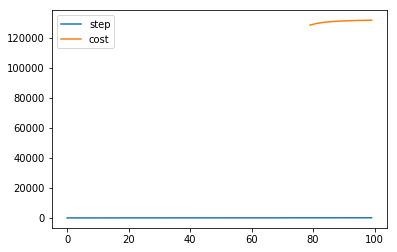

In [11]:
df_cost = df_params[['step','cost']]
df_cost.plot(kind='line')